In [1]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

import torchvision.datasets as datasets

import os
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
import pandas as pd

import torch

from collections import defaultdict, Counter

from plotting.plotting_functions import plot_heatplot, plot_degrees_histogram, plot_counts, plot_eigenvalues, plot_example_nodes, plot_graph

In [2]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

data = Planetoid('./data/Planetoid', name='Cora')[0]

label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

/Users/benbradshaw/Documents/Code/2023/cora/torch/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exis

In [3]:
print(f'Number of nodes: {data.num_nodes}')
# Number of nodes: 2708

print(f'Number of edges: {data.num_edges}')
# Number of edges: 10556

print(f'Average Degree: {round(data.num_edges / data.num_nodes, 1)}')
# Number of edges: 10556

# Graph Features
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Is undirected: {data.num_edge_features}')
print(f'Is undirected: {data.num_node_features}')

Number of nodes: 2708
Number of edges: 10556
Average Degree: 3.9
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Is undirected: 0
Is undirected: 1433


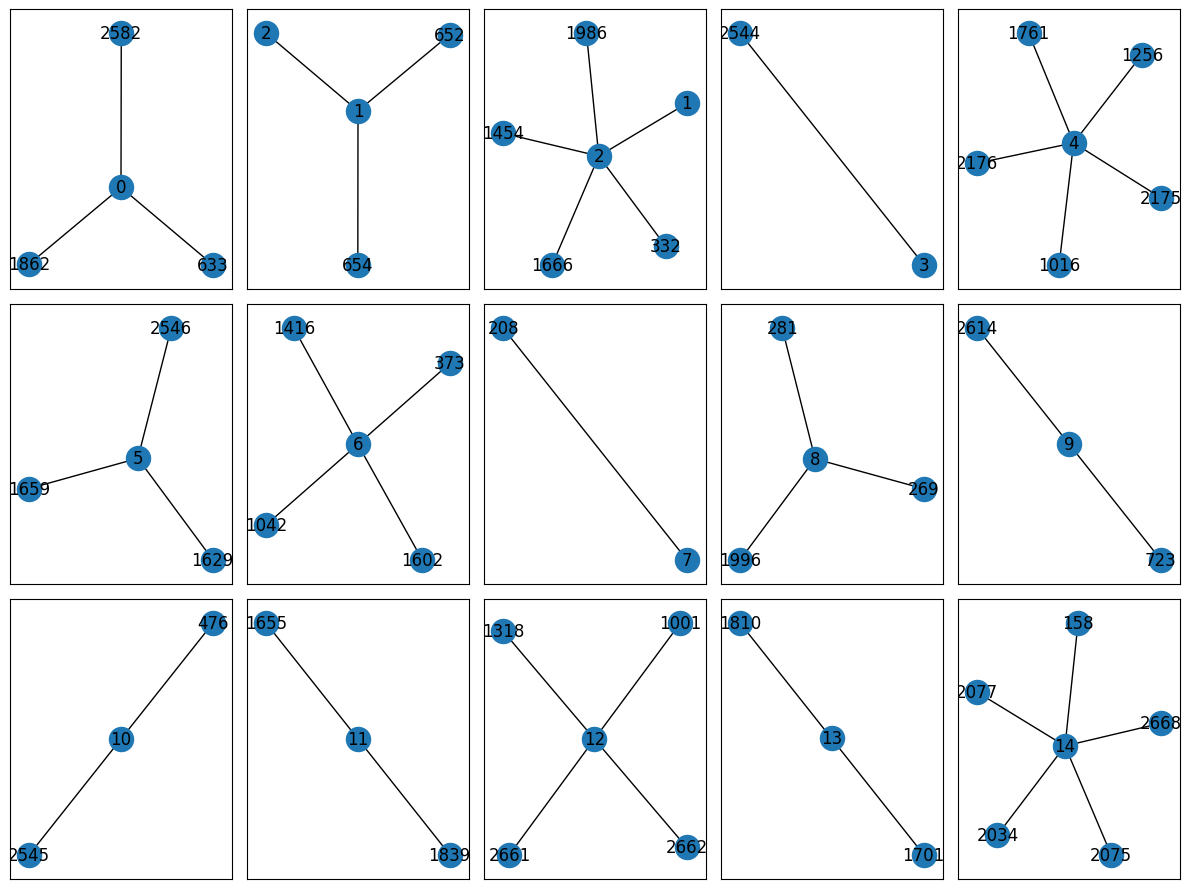

In [4]:
plot_example_nodes(data)

In [5]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))

plot_degrees_histogram(degrees)

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


In [6]:
counter = Counter(data.y.numpy())
counter = dict(counter)
keys = sorted(counter.keys())
index_storage = defaultdict(list)

count = [x[1] for x in sorted(counter.items())]

plot_counts(count)

In [7]:
G = to_networkx(data, to_undirected=True)

L = nx.normalized_laplacian_matrix(G)
eiegnvalues = np.linalg.eigvals(L.toarray())

print("Largest eigenvalue:", max(eiegnvalues))
print("Smallest eigenvalue:", min(eiegnvalues))

eiegnvalues.sort()

Largest eigenvalue: (2.0000000000000537+0j)
Smallest eigenvalue: (-4.3700837599779414e-15+0j)


In [8]:
abs_e = [abs(eigenvalue) for eigenvalue in eiegnvalues] # Removing complex eigenvalues due to rounding errors.

plot_eigenvalues(abs_e)

In [9]:
num_components = nx.number_connected_components(G)
print('Number of Components: ', num_components)

complex_eigenvalues = [ev for ev in eiegnvalues if np.iscomplex(ev)]
print('Number of complex eigenvalues: ', len(complex_eigenvalues))

zero_eigen_values = [eigenvalue for eigenvalue in eiegnvalues if np.abs(eigenvalue) < 1e-9]
print('Number of non-zero eigenvalues: ', len(zero_eigen_values))

non_zero_eigen_values = [eigenvalue for eigenvalue in eiegnvalues if np.abs(eigenvalue) > 1e-9]
print('Number of zero eigenvalues: ', len(non_zero_eigen_values))

complex_eigenvalues = [ev for ev in non_zero_eigen_values if np.iscomplex(ev)]
print('Number of Remaining non-zero Complex Eigenvalues: ', len(complex_eigenvalues))

non_complex_eigenvalues = [np.abs(ev)for ev in non_zero_eigen_values]

Number of Components:  78
Number of complex eigenvalues:  44
Number of non-zero eigenvalues:  78
Number of zero eigenvalues:  2630
Number of Remaining non-zero Complex Eigenvalues:  2


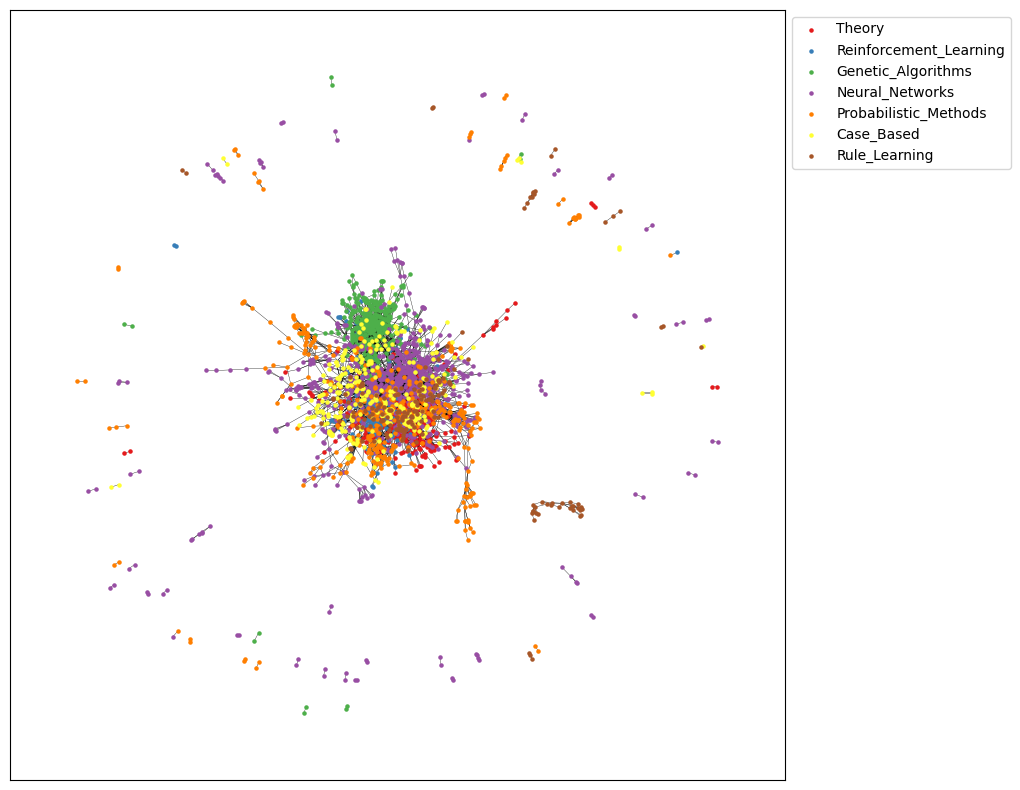

In [10]:
plot_graph(data, label_dict)

In [11]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)

def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []


for i in range(7):
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    counter = Counter(connected_labels[1])
    counter = dict(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)


label_connection_counts = np.array(label_connection_counts)

plot_heatplot(counts=label_connection_counts, label_dict=label_dict, title='Heatmap')

In [12]:
same_edges = label_connection_counts.diagonal().sum().item()
total_edges = label_connection_counts.sum().item()
print(f'Nodes Connected to Same Nodes: {(100*same_edges/total_edges):.2f}%')

Nodes Connected to Same Nodes: 81.00%


In [13]:
def scaling(array):
    return array / sum(array)

label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)

plot_heatplot(label_connection_counts_scaled, label_dict, title='Heatmap with Scaled Values')